In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhavyegupta17","key":"7af0f01c2b205e4040a2cebba7a3aead"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json  ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:32<00:00, 66.4MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.8MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
labels = ['PNEUMONIA','NORMAL']
img_size = 150
def get_data(data_dir):
    data =[]
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try :
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr,(img_size,img_size)) #Reshaping Images to preferred Size
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('/content/chest_xray/train')
test = get_data('/content/chest_xray/test')
val = get_data('/content/chest_xray/val')

<ipython-input-47-76e38656cdbc>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_val_generator.flow_from_directory('/content/chest_xray/train',
                                               batch_size=128,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 5216 images belonging to 2 classes.


In [ ]:
val_data = train_val_generator.flow_from_directory('/content/chest_xray/val',
                                               batch_size=4,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [ ]:
test_data = test_generator.flow_from_directory('/content/chest_xray/test',
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 624 images belonging to 2 classes.


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train :
    x_train.append(feature)
    y_train.append(label)
for feature, label in test :
    x_test.append(feature)
    y_test.append(label)
for feature, label in val :
    x_val.append(feature)
    y_val.append(label)

In [ ]:
positives = []
negatives =[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else : 
        negatives.append(x_train[i])

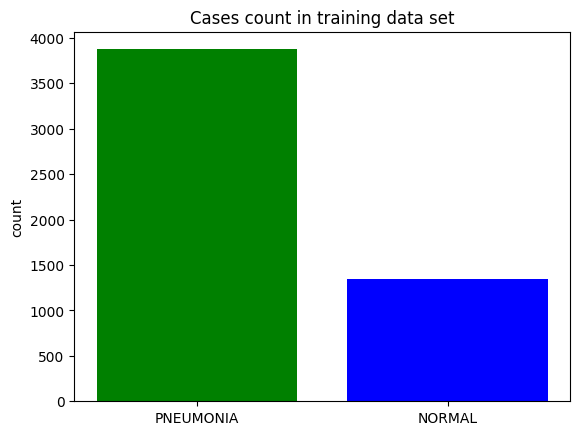

In [ ]:
plt.bar(labels,[len(negatives),len(positives)],color=["green","blue"])
plt.title("Cases count in training data set")
plt.ylabel("count")
plt.show()

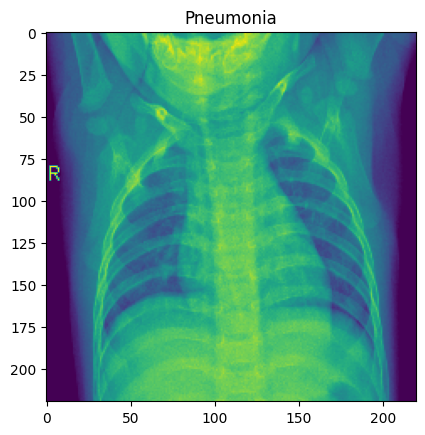

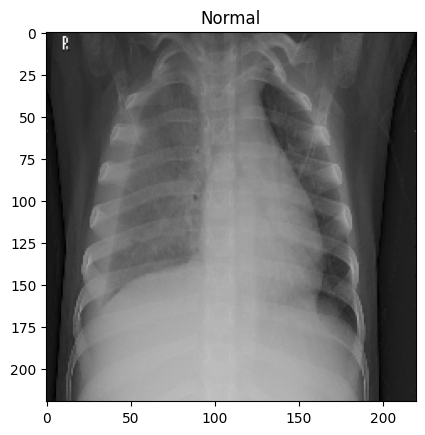

In [ ]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4],cmap="gray")
plt.title("Normal")
plt.show()

In [ ]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset 
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2, # Randomly zoom image 
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range =0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=False # randomly flip images
)

datagen.fit(x_train)

In [ ]:
from keras.applications import ResNet50V2

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
import tensorflow as tf

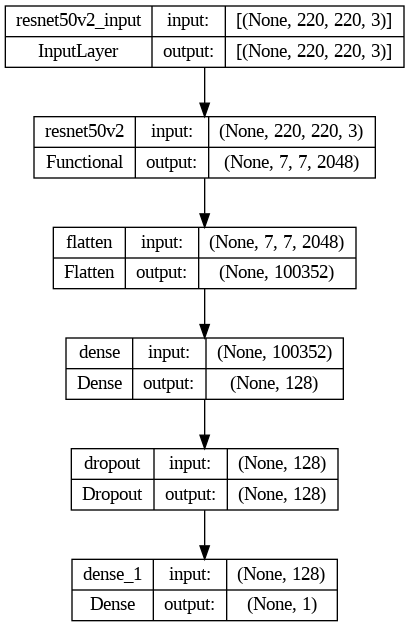

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)

In [ ]:
hist = model.fit(train_data,validation_data=val_data,epochs=5)


Epoch 1/5
41/41 [==============================] - 1105s 27s/step - loss: 2.6286 - accuracy: 0.8194 - val_loss: 0.2973 - val_accuracy: 0.8750
Epoch 2/5
41/41 [==============================] - 1098s 27s/step - loss: 0.2134 - accuracy: 0.9133 - val_loss: 0.1863 - val_accuracy: 0.9375
Epoch 3/5
41/41 [==============================] - 1121s 27s/step - loss: 0.1727 - accuracy: 0.9363 - val_loss: 0.5368 - val_accuracy: 0.7500
Epoch 4/5
41/41 [==============================] - 1097s 27s/step - loss: 0.1528 - accuracy: 0.9436 - val_loss: 0.6627 - val_accuracy: 0.8125
Epoch 5/5
41/41 [==============================] - 1067s 26s/step - loss: 0.1525 - accuracy: 0.9448 - val_loss: 1.2312 - val_accuracy: 0.6875


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('/content/model_new','wb'))

In [ ]:
model=pickle.load(open('/content/drive/MyDrive/model_new','rb'))

In [ ]:
test_results = model.evaluate(test_data)

20/20 [==============================] - 133s 7s/step - loss: 0.2540 - accuracy: 0.9199
